<a href="https://www.kaggle.com/code/dataranch/indian-economy-xgboost-fastai-eda?scriptVersionId=108131941" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Indian Economy Dataset Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.
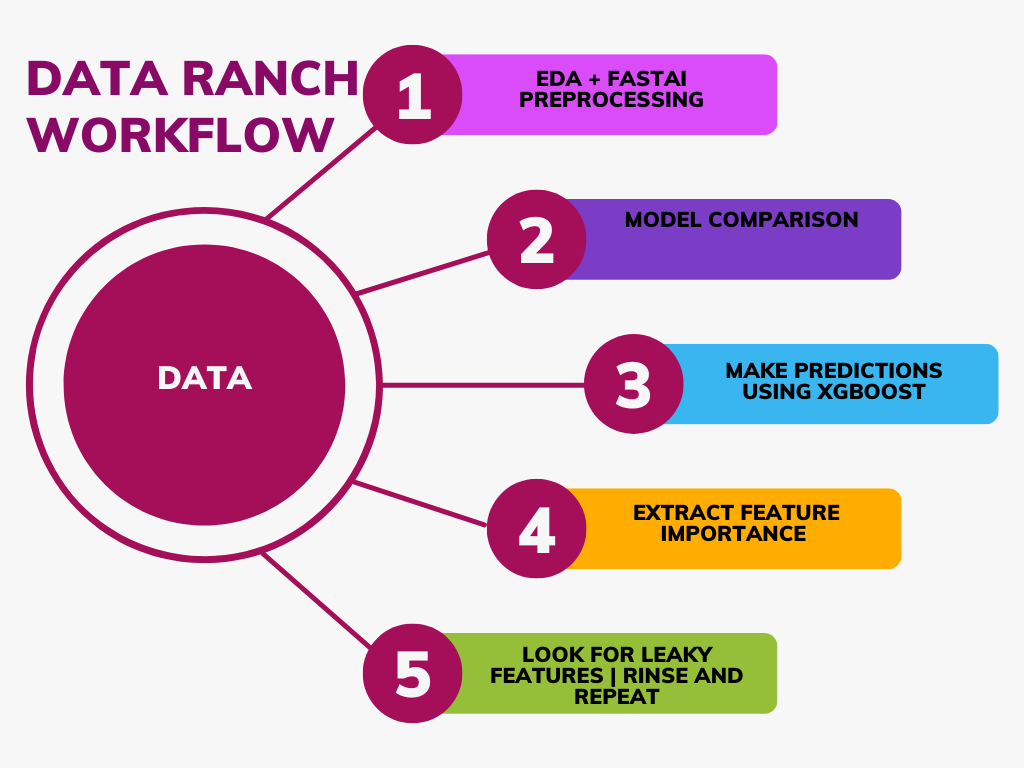

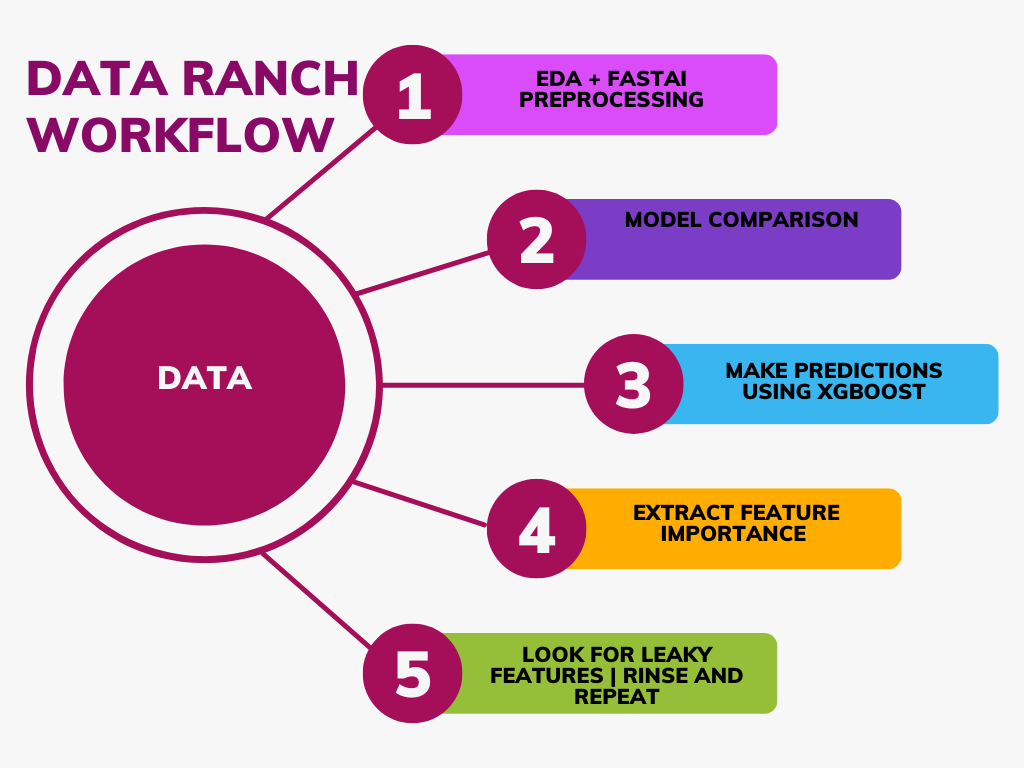

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.3 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'indian-economy-from-1960-to-2020'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/indian-economy-from-1960-to-2020
CSV!


In [12]:
df

Year Country Name  GDP (current US$)    GDP per capita (current US$)   \
0   1960        India      37029883876.18                              82   
1   1961        India      39232435784.04                              85   
2   1962        India      42161481858.08                              90   
3   1963        India      48421923459.12                             101   
4   1964        India      56480289940.99                             116   
..   ...          ...                 ...                             ...   
56  2016        India    2294797980509.01                            1733   
57  2017        India    2651472946374.91                            1981   
58  2018        India    2702929718960.46                            1997   
59  2019        India    2831552222519.99                            2101   
60  2020        India    2667687951796.56                            1928   

    GDP growth (annual %)  Imports of goods and services (% of GDP)  \
0                    0.00                                      6.83   
1                    3.72                                      5.96   
2                    2.93                                      6.03   
3                    5.99                                      5.91   
4                    7.45                                      5.69   
..                    ...                                       ...   
56                   8.26                                     20.92   
57                   6.80                                     21.95   
58                   6.53                                     23.69   
59                   4.04                                     21.27   
60                  -7.25                                     19.10   

    Exports of goods and services (% of GDP)  \
0                                       4.46   
1                                       4.30   
2                                       4.17   
3                                       4.28   
4                                       3.73   
..                                       ...   
56                                     19.16   
57                                     18.79   
58                                     19.93   
59                                     18.69   
60                                     18.71   

     Total reserves (includes gold, current US$)   \
0                                    674536630.93   
1                                    666357094.86   
2                                    512791844.00   
3                                    607862500.36   
4                                    499145125.79   
..                                            ...   
56                                361694321972.04   
57                                412613792019.92   
58                                399167159226.68   
59                                463469902152.51   
60                                590227359928.90   

    Inflation, consumer prices (annual %)  Population, total  \
0                                    1.78          445954579   
1                                    1.70          456351876   
2                                    3.63          467024193   
3                                    2.95          477933619   
4                                   13.36          489059309   
..                                    ...                ...   
56                                   4.95         1338636340   
57                                   3.33         1354195680   
58                                   3.94         1369003306   
59                                   3.73         1383112050   
60                                   6.62         1396387127   

    Population growth (annual %)  Life expectancy at birth, total (years)  
0                           2.31                                    41.13  
1                           2.33                                    41.74  
2              

In [13]:
df.isna().sum()

Year                                             0
Country Name                                     0
GDP (current US$)                                0
 GDP per capita (current US$)                    0
GDP growth (annual %)                            0
Imports of goods and services (% of GDP)         0
Exports of goods and services (% of GDP)         0
 Total reserves (includes gold, current US$)     0
Inflation, consumer prices (annual %)            0
Population, total                                0
Population growth (annual %)                     0
Life expectancy at birth, total (years)          0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

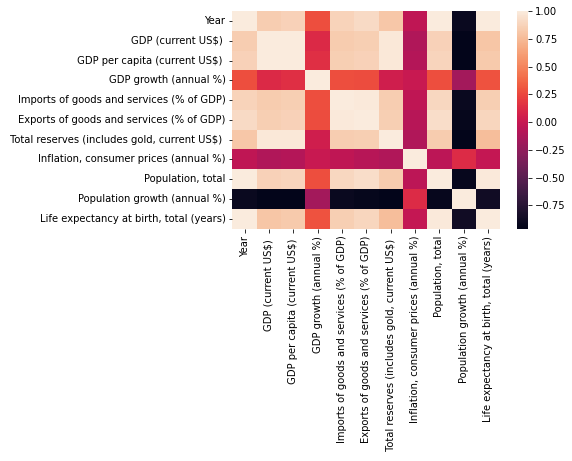

In [15]:
sns.heatmap(df.corr())

In [16]:
df.head().style.background_gradient(cmap = "inferno")

In [17]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [18]:
df.columns

Index(['Year', 'Country Name', 'GDP (current US$) ',
       ' GDP per capita (current US$) ', 'GDP growth (annual %)',
       'Imports of goods and services (% of GDP)',
       'Exports of goods and services (% of GDP)',
       ' Total reserves (includes gold, current US$) ',
       'Inflation, consumer prices (annual %)', 'Population, total',
       'Population growth (annual %)',
       'Life expectancy at birth, total (years)'],
      dtype='object')

In [19]:
#remove 'Unnamed:0' as it's a leaky feature
del(df['Year'])
del(df['Country Name'])

Target Variable: Life expectancy at birth, total (years)
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:01, 30.80it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9953042384152673, 'Adjusted R-Squared': 0.97417331128397, 'RMSE': 0.6567302774174221, 'Time taken': 0.08003067970275879}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9941185242487313, 'Adjusted R-Squared': 0.9676518833680219, 'RMSE': 0.7349827989220789, 'Time taken': 0.02677440643310547}
{'Model': 'BayesianRidge', 'R-Squared': 0.9928995163541363, 'Adjusted R-Squared': 0.9609473399477497, 'RMSE': 0.80756592471595, 'Time taken': 0.030564308166503906}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9870878621050087, 'Adjusted R-Squared': 0.9289832415775476, 'RMSE': 1.0890130838148537, 'Time taken': 0.010102033615112305}
{'Model': 'DummyRegressor', 'R-Squared': -0.03380491282321629, 'Adjusted R-Squared': -4.685927020527689, 'RMSE': 9.74436, 'Time taken': 0.009185314178466797}
{'Model': 'ElasticNet', 'R-Squared': 0.8896854990604209, 'Adjusted R-Squared': 0.3932702448323151, 'RMSE': 3.1831002, 'Time taken': 0.013438940048217773}
{'Model': 'Elas

 31%|███       | 13/42 [00:00<00:01, 21.95it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.998391174651184, 'Adjusted R-Squared': 0.9911514605815119, 'RMSE': 0.38440450619500727, 'Time taken': 0.10863995552062988}
{'Model': 'GammaRegressor', 'R-Squared': 0.8718626003145314, 'Adjusted R-Squared': 0.2952443017299229, 'RMSE': 3.430614928266922, 'Time taken': 0.013137578964233398}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.321253426748433, 'Adjusted R-Squared': -28.26689384711638, 'RMSE': 22.107569107188493, 'Time taken': 0.016227245330810547}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9974419686347495, 'Adjusted R-Squared': 0.9859308274911225, 'RMSE': 0.4847155500810377, 'Time taken': 0.08495974540710449}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8611249165147585, 'Adjusted R-Squared': 0.23618704083117192, 'RMSE': 3.5714632559174415, 'Time taken': 0.0772101879119873}


 52%|█████▏    | 22/42 [00:00<00:00, 31.29it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9871957442351895, 'Adjusted R-Squared': 0.9295765932935424, 'RMSE': 1.0844541377108325, 'Time taken': 0.03726363182067871}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9351830308708156, 'Adjusted R-Squared': 0.6435066697894856, 'RMSE': 2.439936, 'Time taken': 0.01036381721496582}
{'Model': 'KernelRidge', 'R-Squared': -34.16741319633389, 'Adjusted R-Squared': -192.42077257983638, 'RMSE': 56.833477, 'Time taken': 0.019480228424072266}
{'Model': 'Lars', 'R-Squared': 0.5758341636271656, 'Adjusted R-Squared': -1.3329121000505895, 'RMSE': 6.2416854, 'Time taken': 0.013151884078979492}
{'Model': 'LarsCV', 'R-Squared': 0.9915849854883395, 'Adjusted R-Squared': 0.9537174201858674, 'RMSE': 0.8791469, 'Time taken': 0.0232694149017334}
{'Model': 'Lasso', 'R-Squared': 0.9637751924105279, 'Adjusted R-Squared': 0.8007635582579034, 'RMSE': 1.8240515, 'Time taken': 0.011208057403564453}
{'Model': 'LassoCV', 'R-Squared': 0.993410614608737, 'Adjusted R-Square

 62%|██████▏   | 26/42 [00:00<00:00, 28.46it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.9862025466695334, 'Adjusted R-Squared': 0.9241140066824339, 'RMSE': 1.125728, 'Time taken': 0.012321233749389648}
{'Model': 'LinearSVR', 'R-Squared': 0.013366626213406008, 'Adjusted R-Squared': -4.426483555826267, 'RMSE': 9.519451394496704, 'Time taken': 0.010139226913452148}
{'Model': 'MLPRegressor', 'R-Squared': -9.874714728428321, 'Adjusted R-Squared': -58.810931006355766, 'RMSE': 31.604065, 'Time taken': 0.12160515785217285}
{'Model': 'NuSVR', 'R-Squared': 0.5694142822776708, 'Adjusted R-Squared': -1.368221447472811, 'RMSE': 6.288742755827331, 'Time taken': 0.010953903198242188}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9737318101173976, 'Adjusted R-Squared': 0.855524955645687, 'RMSE': 1.5532776502529277, 'Time taken': 0.009929895401000977}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9928653228648989, 'Adjusted R-Squared': 0.9607592757569441, 'RMSE': 0.8095080693401342, 'Time taken': 0.015090227127075195}
{'Model'

 76%|███████▌  | 32/42 [00:01<00:00, 33.05it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.008851666688451942, 'Adjusted R-Squared': -4.548684166786486, 'RMSE': 9.62604034889254, 'Time taken': 0.07637166976928711}
{'Model': 'RANSACRegressor', 'R-Squared': 0.986202593067012, 'Adjusted R-Squared': 0.9241142618685658, 'RMSE': 1.1257261, 'Time taken': 0.03273177146911621}


 86%|████████▌ | 36/42 [00:01<00:00, 25.78it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9961797187001369, 'Adjusted R-Squared': 0.9789884528507529, 'RMSE': 0.5923544987700319, 'Time taken': 0.18500947952270508}
{'Model': 'Ridge', 'R-Squared': 0.9856089253285836, 'Adjusted R-Squared': 0.9208490893072097, 'RMSE': 1.1496897, 'Time taken': 0.011133432388305664}
{'Model': 'RidgeCV', 'R-Squared': 0.9935989979815257, 'Adjusted R-Squared': 0.9647944888983915, 'RMSE': 0.7667574456404126, 'Time taken': 0.010361909866333008}
{'Model': 'SGDRegressor', 'R-Squared': 0.9840828213490125, 'Adjusted R-Squared': 0.9124555174195687, 'RMSE': 1.2091134861536037, 'Time taken': 0.013721942901611328}
{'Model': 'SVR', 'R-Squared': 0.6513873700954274, 'Adjusted R-Squared': -0.9173694644751496, 'RMSE': 5.658555480949922, 'Time taken': 0.009836435317993164}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9862025466695334, 'Adjusted R-Squared': 0.9241140066824339, 'RMSE': 1.125728, 'Time taken': 0.010384321212768555}
{'Model': 'TweedieRegressor'

100%|██████████| 42/42 [00:01<00:00, 22.80it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9911606673174509, 'Adjusted R-Squared': 0.9513836702459799, 'RMSE': 0.90103936, 'Time taken': 0.3905644416809082}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8447537963566359, 'Adjusted R-Squared': 0.14614587996149764, 'RMSE': 3.776108932557612, 'Time taken': 0.08512163162231445}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: Life expectancy at birth, total (years)
Life expectancy at birth, total (years)
Target Standard Deviation: 8.032773971557617
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.99       1.00  0.38        0.11
GradientBoostingRegressor                    0.99       1.00  0.48        0.08
RandomForestRegressor                        0.98       1.00  0.59        0.19
AdaBoostRegressor                            0.97       1.00  0.66        0.0

Better model found at epoch 0 with _rmse value: 103.70939636230469.
No improvement since epoch 0: early stopping


<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   69.73      69.50
1   57.18      58.96
2   58.15      58.19
3   65.12      65.61
4   48.06      49.85
XGBoost RMSE:  0.90577847


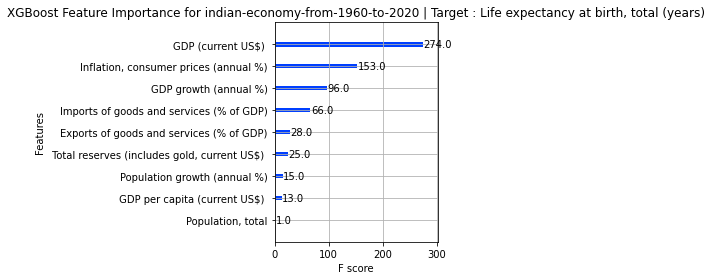

Target Variable: Population growth (annual %)
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:01, 33.77it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9720249303299823, 'Adjusted R-Squared': 0.8461371168149026, 'RMSE': 0.07922092208456988, 'Time taken': 0.07578802108764648}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9765791746145354, 'Adjusted R-Squared': 0.8711854603799445, 'RMSE': 0.07248621164067909, 'Time taken': 0.027375221252441406}
{'Model': 'BayesianRidge', 'R-Squared': 0.9666391120311514, 'Adjusted R-Squared': 0.8165151161713327, 'RMSE': 0.0865113532530762, 'Time taken': 0.012388467788696289}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9800526834647598, 'Adjusted R-Squared': 0.890289759056179, 'RMSE': 0.06689544457326167, 'Time taken': 0.009516477584838867}
{'Model': 'DummyRegressor', 'R-Squared': -0.03245087438927907, 'Adjusted R-Squared': -4.6784798091410345, 'RMSE': 0.48127022, 'Time taken': 0.008577823638916016}
{'Model': 'ElasticNet', 'R-Squared': -0.03245087438927907, 'Adjusted R-Squared': -4.6784798091410345, 'RMSE': 0.48127022, 'Time taken': 0.009427070617675781}


 26%|██▌       | 11/42 [00:00<00:01, 30.31it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9761202078659253, 'Adjusted R-Squared': 0.8686611432625895, 'RMSE': 0.0731930046341675, 'Time taken': 0.11036348342895508}
{'Model': 'GammaRegressor', 'R-Squared': 0.929320428889976, 'Adjusted R-Squared': 0.611262358894868, 'RMSE': 0.1259218969201374, 'Time taken': 0.012407779693603516}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.3721447438813437, 'Adjusted R-Squared': -12.04679609134739, 'RMSE': 0.7294993299204761, 'Time taken': 0.01220083236694336}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9814975005225411, 'Adjusted R-Squared': 0.8982362528739762, 'RMSE': 0.06442723672906381, 'Time taken': 0.08793497085571289}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5787699964126654, 'Adjusted R-Squared': -1.3167650197303407, 'RMSE': 0.30740714218474957, 'Time taken': 0.05599498748779297}
{'Model': 'HuberRegressor', 'R-Squared': 0.9652453732585882, 'Adjusted R-Squared': 0.8088495529222349, 'RMSE': 0.0882999827934

 48%|████▊     | 20/42 [00:00<00:00, 29.15it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9429128317135953, 'Adjusted R-Squared': 0.6860205744247742, 'RMSE': 0.11316798, 'Time taken': 0.011638402938842773}
{'Model': 'KernelRidge', 'R-Squared': -15.347386936668702, 'Adjusted R-Squared': -88.91062815167786, 'RMSE': 1.9150426, 'Time taken': 0.012798070907592773}
{'Model': 'Lars', 'R-Squared': -215690.94646952164, 'Adjusted R-Squared': -1186304.7055823691, 'RMSE': 219.97395, 'Time taken': 0.01282358169555664}
{'Model': 'LarsCV', 'R-Squared': 0.07058941245599293, 'Adjusted R-Squared': -4.111758231492039, 'RMSE': 0.45662335, 'Time taken': 0.02400970458984375}
{'Model': 'Lasso', 'R-Squared': -0.03245087438927907, 'Adjusted R-Squared': -4.6784798091410345, 'RMSE': 0.48127022, 'Time taken': 0.010464906692504883}
{'Model': 'LassoCV', 'R-Squared': 0.979093976910854, 'Adjusted R-Squared': 0.8850168730096969, 'RMSE': 0.06848414, 'Time taken': 0.07512044906616211}
{'Model': 'LassoLars', 'R-Squared': -0.03245087438927907, 'Adjusted R-Squared

 62%|██████▏   | 26/42 [00:00<00:00, 29.20it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.9608669958461714, 'Adjusted R-Squared': 0.7847684771539427, 'RMSE': 0.09369705, 'Time taken': 0.01355290412902832}
{'Model': 'LinearSVR', 'R-Squared': 0.9774878605654451, 'Adjusted R-Squared': 0.8761832331099482, 'RMSE': 0.07106613386756697, 'Time taken': 0.014151334762573242}
{'Model': 'MLPRegressor', 'R-Squared': 0.8286253256831339, 'Adjusted R-Squared': 0.057439291257236125, 'RMSE': 0.19607744, 'Time taken': 0.11743974685668945}
{'Model': 'NuSVR', 'R-Squared': 0.6470447038946858, 'Adjusted R-Squared': -0.941254128579228, 'RMSE': 0.2813935614065365, 'Time taken': 0.01211690902709961}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8789468529132538, 'Adjusted R-Squared': 0.33420769102289594, 'RMSE': 0.1647943610555787, 'Time taken': 0.010042667388916016}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9840849461325745, 'Adjusted R-Squared': 0.9124672037291596, 'RMSE': 0.059752813768569016, 'Time taken': 0.015369415283203125}
{

 76%|███████▌  | 32/42 [00:01<00:00, 31.45it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.40340710758492415, 'Adjusted R-Squared': -6.718739091717083, 'RMSE': 0.5611075862754129, 'Time taken': 0.1064763069152832}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9608668598697759, 'Adjusted R-Squared': 0.7847677292837676, 'RMSE': 0.09369721, 'Time taken': 0.03161168098449707}


 86%|████████▌ | 36/42 [00:01<00:00, 25.54it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9754779831290916, 'Adjusted R-Squared': 0.8651289072100039, 'RMSE': 0.07417070346898746, 'Time taken': 0.18497824668884277}
{'Model': 'Ridge', 'R-Squared': 0.979467209222482, 'Adjusted R-Squared': 0.8870696507236508, 'RMSE': 0.06787007, 'Time taken': 0.01087641716003418}
{'Model': 'RidgeCV', 'R-Squared': 0.9786294512758658, 'Adjusted R-Squared': 0.8824619820172617, 'RMSE': 0.06924081026507854, 'Time taken': 0.009810686111450195}
{'Model': 'SGDRegressor', 'R-Squared': 0.9769036705961454, 'Adjusted R-Squared': 0.8729701882787995, 'RMSE': 0.07198231124429115, 'Time taken': 0.011053085327148438}
{'Model': 'SVR', 'R-Squared': 0.6408733314563598, 'Adjusted R-Squared': -0.9751966769900209, 'RMSE': 0.2838429638566247, 'Time taken': 0.009281158447265625}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9608669958461714, 'Adjusted R-Squared': 0.7847684771539427, 'RMSE': 0.09369705, 'Time taken': 0.00967717170715332}
{'Model': 'TweedieRegres

100%|██████████| 42/42 [00:01<00:00, 23.91it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9760424751918647, 'Adjusted R-Squared': 0.868233613555256, 'RMSE': 0.07331204, 'Time taken': 0.3635382652282715}
{'Model': 'LGBMRegressor', 'R-Squared': 0.579960071586738, 'Adjusted R-Squared': -1.3102196062729408, 'RMSE': 0.3069725858077096, 'Time taken': 0.03958630561828613}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: Population growth (annual %)
Population growth (annual %)
Target Standard Deviation: 0.3982771933078766
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
OrthogonalMatchingPursuitCV                  0.91       0.98   0.06   
GradientBoostingRegressor                    0.90       0.98   0.06   
DecisionTreeRegressor                        0.89       0.98   0.07   
ElasticNetCV                                 0.89       0.98   0.07   
Ridge                                        0.89       0.98   0.07 

Better model found at epoch 0 with _rmse value: 38.60154342651367.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    2.01       1.97
1    2.24       2.24
2    2.15       2.19
3    2.34       2.32
4    1.74       1.86
XGBoost RMSE:  0.07331204


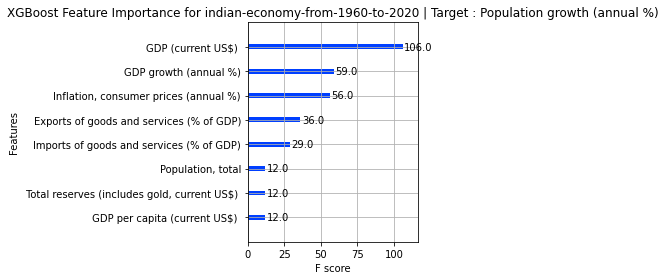

Target Variable: Population, total
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 19%|█▉        | 8/42 [00:00<00:00, 40.20it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.994781913096659, 'Adjusted R-Squared': 0.9713005220316244, 'RMSE': 22065425.903302643, 'Time taken': 0.07797694206237793}
{'Model': 'BaggingRegressor', 'R-Squared': 0.996993393520616, 'Adjusted R-Squared': 0.9834636643633881, 'RMSE': 16749234.200037217, 'Time taken': 0.028387784957885742}
{'Model': 'BayesianRidge', 'R-Squared': -0.03098000915738397, 'Adjusted R-Squared': -4.6703900503656115, 'RMSE': 310157139.67595994, 'Time taken': 0.011009454727172852}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.989759888982371, 'Adjusted R-Squared': 0.9436793894030404, 'RMSE': 30910710.89516892, 'Time taken': 0.009494781494140625}
{'Model': 'DummyRegressor', 'R-Squared': -0.030980036507947117, 'Adjusted R-Squared': -4.670390200793709, 'RMSE': 310157150.0, 'Time taken': 0.008668899536132812}
{'Model': 'ElasticNet', 'R-Squared': 0.9452660785646824, 'Adjusted R-Squared': 0.698963432105753, 'RMSE': 71463610.0, 'Time taken': 0.01112222671508789}
{'Model

 29%|██▊       | 12/42 [00:00<00:01, 25.65it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9995106571311895, 'Adjusted R-Squared': 0.9973086142215422, 'RMSE': 6757145.842134212, 'Time taken': 0.11365580558776855}
{'Model': 'GammaRegressor', 'R-Squared': 0.8851517685959668, 'Adjusted R-Squared': 0.36833472727781724, 'RMSE': 103518701.69744334, 'Time taken': 0.012445211410522461}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.8658078243280991, 'Adjusted R-Squared': 0.2619430338045451, 'RMSE': 111897467.5694859, 'Time taken': 0.012127876281738281}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9983478383570482, 'Adjusted R-Squared': 0.9909131109637652, 'RMSE': 12416035.004732624, 'Time taken': 0.08925795555114746}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9042343000202554, 'Adjusted R-Squared': 0.47328865011140464, 'RMSE': 94528257.95052792, 'Time taken': 0.06958150863647461}
{'Model': 'HuberRegressor', 'R-Squared': -0.033153275312549635, 'Adjusted R-Squared': -4.682343014219023, 'RMSE': 310483867.2373

 48%|████▊     | 20/42 [00:00<00:00, 31.87it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9750943072330553, 'Adjusted R-Squared': 0.8630186897818044, 'RMSE': 48206544.0, 'Time taken': 0.013355255126953125}
{'Model': 'KernelRidge', 'R-Squared': -7.507942610016887, 'Adjusted R-Squared': -45.79368435509288, 'RMSE': 890982000.0, 'Time taken': 0.010386228561401367}
{'Model': 'Lars', 'R-Squared': 0.9653404996600667, 'Adjusted R-Squared': 0.8093727481303671, 'RMSE': 56867980.0, 'Time taken': 0.010765552520751953}
{'Model': 'LarsCV', 'R-Squared': 0.9945693332744402, 'Adjusted R-Squared': 0.970131333009421, 'RMSE': 22510402.0, 'Time taken': 0.0225827693939209}
{'Model': 'Lasso', 'R-Squared': 0.9943240250472324, 'Adjusted R-Squared': 0.9687821377597781, 'RMSE': 23013192.0, 'Time taken': 0.01112222671508789}
{'Model': 'LassoCV', 'R-Squared': 0.9945688377201674, 'Adjusted R-Squared': 0.9701286074609204, 'RMSE': 22511428.0, 'Time taken': 0.05896925926208496}
{'Model': 'LassoLars', 'R-Squared': 0.9947682212443236, 'Adjusted R-Squared': 0.97

 76%|███████▌  | 32/42 [00:01<00:00, 32.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': -9.360995987687375, 'Adjusted R-Squared': -55.98547793228056, 'RMSE': 983235200.0, 'Time taken': 0.12422537803649902}
{'Model': 'NuSVR', 'R-Squared': -0.032053357423860396, 'Adjusted R-Squared': -4.6762934658312325, 'RMSE': 310318549.2200139, 'Time taken': 0.012069940567016602}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9727648794560297, 'Adjusted R-Squared': 0.8502068370081636, 'RMSE': 50410535.5862227, 'Time taken': 0.0100250244140625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9947821887117191, 'Adjusted R-Squared': 0.971302037914455, 'RMSE': 22064843.156780142, 'Time taken': 0.01591181755065918}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -9.36001451861226, 'Adjusted R-Squared': -55.98007985236743, 'RMSE': 983188619.0867553, 'Time taken': 0.013838768005371094}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9977535982609531, 'Adjusted R-Squared': 0.9876447904352421, 'RMSE': 14477726.698789122, 'Time taken': 0.0237

 86%|████████▌ | 36/42 [00:01<00:00, 26.02it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9979451405751975, 'Adjusted R-Squared': 0.988698273163586, 'RMSE': 13846745.78684295, 'Time taken': 0.1865983009338379}
{'Model': 'Ridge', 'R-Squared': 0.9956165861170809, 'Adjusted R-Squared': 0.9758912236439451, 'RMSE': 20223806.0, 'Time taken': 0.010468244552612305}
{'Model': 'RidgeCV', 'R-Squared': 0.994830310189175, 'Adjusted R-Squared': 0.9715667060404625, 'RMSE': 21962860.519320924, 'Time taken': 0.010290384292602539}
{'Model': 'SGDRegressor', 'R-Squared': 0.994898309041342, 'Adjusted R-Squared': 0.9719406997273812, 'RMSE': 21817939.55695555, 'Time taken': 0.015411615371704102}
{'Model': 'SVR', 'R-Squared': -0.07306850057743675, 'Adjusted R-Squared': -4.901876753175902, 'RMSE': 316424705.0704206, 'Time taken': 0.010306596755981445}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.994767848291846, 'Adjusted R-Squared': 0.9712231656051526, 'RMSE': 22095144.0, 'Time taken': 0.010366439819335938}
{'Model': 'TweedieRegressor', '

100%|██████████| 42/42 [00:01<00:00, 23.76it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9949116932932569, 'Adjusted R-Squared': 0.972014313112913, 'RMSE': 21789300.0, 'Time taken': 0.39494991302490234}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8698834042312809, 'Adjusted R-Squared': 0.2843587232720447, 'RMSE': 110185134.69034986, 'Time taken': 0.042664527893066406}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: Population, total
Population, total
Target Standard Deviation: 291408672.0
                               Adjusted R-Squared  R-Squared         RMSE  \
Model                                                                       
ExtraTreesRegressor                          1.00       1.00   6757145.84   
GradientBoostingRegressor                    0.99       1.00  12416035.00   
RandomForestRegressor                        0.99       1.00  13846745.79   
PoissonRegressor                             0.99       1.00  14477726.70   
BaggingRegressor                             0.98       1.0

Better model found at epoch 0 with _rmse value: 983235200.0.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
         actual     predicted
0  477933632.00  486206368.00
1  729169472.00  707510912.00
2  596107456.00  634084352.00
3 1154638720.00 1138368384.00
4 1117415168.00 1136631168.00
XGBoost RMSE:  21789300.0


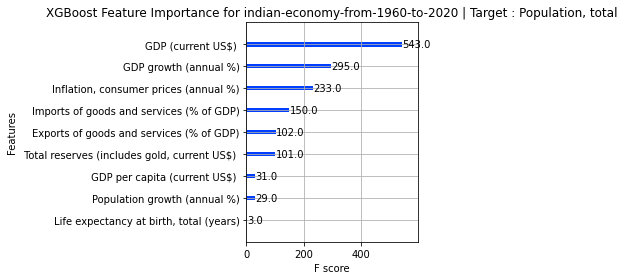

Target Variable: Inflation, consumer prices (annual %)
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:01, 30.84it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.18261135076591906, 'Adjusted R-Squared': -5.504362429212555, 'RMSE': 6.787162458448979, 'Time taken': 0.07648444175720215}
{'Model': 'BaggingRegressor', 'R-Squared': -0.5981897544698371, 'Adjusted R-Squared': -7.790043649584105, 'RMSE': 7.890079773590716, 'Time taken': 0.02682948112487793}
{'Model': 'BayesianRidge', 'R-Squared': -0.10574913820819898, 'Adjusted R-Squared': -5.081620260145094, 'RMSE': 6.562896086206177, 'Time taken': 0.012306451797485352}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.885973524551893, 'Adjusted R-Squared': -14.872854385035412, 'RMSE': 10.602624832507528, 'Time taken': 0.009359121322631836}
{'Model': 'DummyRegressor', 'R-Squared': -0.0764048465949656, 'Adjusted R-Squared': -4.920226656272311, 'RMSE': 6.4752274, 'Time taken': 0.008640289306640625}
{'Model': 'ElasticNet', 'R-Squared': -0.11339564407204827, 'Adjusted R-Squared': -5.123676042396266, 'RMSE': 6.5855484, 'Time taken': 0.009546518325805664}
{'Mod

 31%|███       | 13/42 [00:00<00:01, 22.04it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.29553194836342445, 'Adjusted R-Squared': -6.125425715998834, 'RMSE': 7.103809175454928, 'Time taken': 0.10930752754211426}
{'Model': 'GammaRegressor', 'R-Squared': -0.14934458283238095, 'Adjusted R-Squared': -5.321395205578095, 'RMSE': 6.691020334374017, 'Time taken': 0.012622833251953125}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.9758338241202456, 'Adjusted R-Squared': -26.36708603266135, 'RMSE': 13.921952802401892, 'Time taken': 0.01485443115234375}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.4500425422485561, 'Adjusted R-Squared': -6.975233982367058, 'RMSE': 7.515495085195642, 'Time taken': 0.0836482048034668}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.15068085103491846, 'Adjusted R-Squared': -5.3287446806920515, 'RMSE': 6.694908811589353, 'Time taken': 0.07839441299438477}


 45%|████▌     | 19/42 [00:00<00:00, 32.09it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0008419871935244627, 'Adjusted R-Squared': -4.495369070435616, 'RMSE': 6.238559347709263, 'Time taken': 0.03916287422180176}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.2580784953681219, 'Adjusted R-Squared': -5.919431724524671, 'RMSE': 7.000372, 'Time taken': 0.01026153564453125}
{'Model': 'KernelRidge', 'R-Squared': -0.9598083237612298, 'Adjusted R-Squared': -9.778945780686763, 'RMSE': 8.737235, 'Time taken': 0.009583234786987305}
{'Model': 'Lars', 'R-Squared': -0.10015859143929573, 'Adjusted R-Squared': -5.050872252916126, 'RMSE': 6.546284, 'Time taken': 0.011197566986083984}
{'Model': 'LarsCV', 'R-Squared': -0.13679219676197918, 'Adjusted R-Squared': -5.252357082190885, 'RMSE': 6.654382, 'Time taken': 0.02295660972595215}
{'Model': 'Lasso', 'R-Squared': -0.08304925805353136, 'Adjusted R-Squared': -4.9567709192944225, 'RMSE': 6.495182, 'Time taken': 0.009853363037109375}


 55%|█████▍    | 23/42 [00:00<00:00, 25.72it/s]

{'Model': 'LassoCV', 'R-Squared': -0.1370159507416442, 'Adjusted R-Squared': -5.253587729079043, 'RMSE': 6.6550374, 'Time taken': 0.16731643676757812}
{'Model': 'LassoLars', 'R-Squared': -0.0764048465949656, 'Adjusted R-Squared': -4.920226656272311, 'RMSE': 6.4752274, 'Time taken': 0.01063847541809082}
{'Model': 'LassoLarsCV', 'R-Squared': -0.1320336444706769, 'Adjusted R-Squared': -5.226185044588723, 'RMSE': 6.640441, 'Time taken': 0.02621293067932129}
{'Model': 'LassoLarsIC', 'R-Squared': -0.15488864081406772, 'Adjusted R-Squared': -5.351887524477372, 'RMSE': 6.707139, 'Time taken': 0.01329803466796875}
{'Model': 'LinearRegression', 'R-Squared': -0.10499376040450525, 'Adjusted R-Squared': -5.077465682224779, 'RMSE': 6.5606546, 'Time taken': 0.012646913528442383}
{'Model': 'LinearSVR', 'R-Squared': -0.03631508938994066, 'Adjusted R-Squared': -4.699732991644674, 'RMSE': 6.353501459384508, 'Time taken': 0.01086115837097168}


 76%|███████▌  | 32/42 [00:01<00:00, 27.61it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.16647820760888865, 'Adjusted R-Squared': -5.4156301418488875, 'RMSE': 6.7407084, 'Time taken': 0.13898754119873047}
{'Model': 'NuSVR', 'R-Squared': -0.05718194787921593, 'Adjusted R-Squared': -4.814500713335688, 'RMSE': 6.41714854386146, 'Time taken': 0.01820206642150879}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.17995603410074423, 'Adjusted R-Squared': -5.489758187554093, 'RMSE': 6.7795385703558555, 'Time taken': 0.013692617416381836}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.17995603410074423, 'Adjusted R-Squared': -5.489758187554093, 'RMSE': 6.7795385703558555, 'Time taken': 0.021394729614257812}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.5092852774135337, 'Adjusted R-Squared': -12.801069025774435, 'RMSE': 9.886492525755886, 'Time taken': 0.010505437850952148}
{'Model': 'PoissonRegressor', 'R-Squared': -0.14194570760336056, 'Adjusted R-Squared': -5.280701391818483, 'RMSE': 6.669448929129903, 'Time tak

 83%|████████▎ | 35/42 [00:01<00:00, 20.17it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.014917122805235605, 'Adjusted R-Squared': -4.582044175428796, 'RMSE': 6.2875657, 'Time taken': 0.12382841110229492}
{'Model': 'RandomForestRegressor', 'R-Squared': -0.37288460575111815, 'Adjusted R-Squared': -6.55086533163115, 'RMSE': 7.3128091738678425, 'Time taken': 0.1435706615447998}
{'Model': 'Ridge', 'R-Squared': -0.11969034724277727, 'Adjusted R-Squared': -5.158296909835275, 'RMSE': 6.604139, 'Time taken': 0.01029348373413086}
{'Model': 'RidgeCV', 'R-Squared': -0.11969054814847757, 'Adjusted R-Squared': -5.158298014816626, 'RMSE': 6.604139360745634, 'Time taken': 0.01232290267944336}
{'Model': 'SGDRegressor', 'R-Squared': -0.14127711931190845, 'Adjusted R-Squared': -5.2770241562154965, 'RMSE': 6.667496223187537, 'Time taken': 0.01030421257019043}
{'Model': 'SVR', 'R-Squared': -0.04022438495330083, 'Adjusted R-Squared': -4.721234117243155, 'RMSE': 6.365473848643853, 'Time taken': 0.009804725646972656}
{'Model': 'TransformedTargetRegres

100%|██████████| 42/42 [00:01<00:00, 21.48it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.18920237994956124, 'Adjusted R-Squared': -5.540613089722587, 'RMSE': 6.80605, 'Time taken': 0.3761570453643799}
{'Model': 'LGBMRegressor', 'R-Squared': -0.16499139987262978, 'Adjusted R-Squared': -5.407452699299464, 'RMSE': 6.736411099891504, 'Time taken': 0.03722429275512695}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: Inflation, consumer prices (annual %)
Inflation, consumer prices (annual %)
Target Standard Deviation: 4.445106029510498
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HuberRegressor                              -4.50       0.00  6.24        0.04
QuantileRegressor                           -4.56      -0.01  6.27        0.08
RANSACRegressor                             -4.58      -0.01  6.29        0.12
LinearSVR                                   -4.70      -0.04  6.35        0.01
SV

Better model found at epoch 0 with _rmse value: 20.278240203857422.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   13.06       5.03
1    8.35       6.00
2   -7.63       5.15
3    9.48      11.03
4    6.33       7.23
XGBoost RMSE:  6.80605


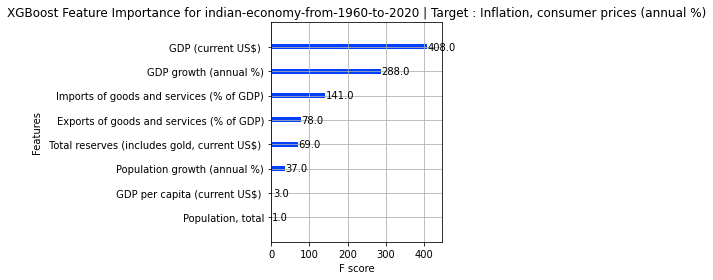

Target Variable:  Total reserves (includes gold, current US$) 
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:00, 36.53it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9174924997182037, 'Adjusted R-Squared': 0.5462087484501202, 'RMSE': 51230032290.06406, 'Time taken': 0.07777976989746094}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8138055172732171, 'Adjusted R-Squared': -0.024069654997305623, 'RMSE': 76959337206.78256, 'Time taken': 0.02807164192199707}
{'Model': 'BayesianRidge', 'R-Squared': -0.00010135025336621695, 'Adjusted R-Squared': -4.500557426393514, 'RMSE': 178361009463.401, 'Time taken': 0.012328624725341797}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7821133552145276, 'Adjusted R-Squared': -0.19837654632009816, 'RMSE': 83251721068.47827, 'Time taken': 0.010061502456665039}
{'Model': 'DummyRegressor', 'R-Squared': -0.00010137949813149305, 'Adjusted R-Squared': -4.500557587239723, 'RMSE': 178361000000.0, 'Time taken': 0.008860111236572266}
{'Model': 'ElasticNet', 'R-Squared': 0.8240424171038213, 'Adjusted R-Squared': 0.03223329407101727, 'RMSE': 74813830000.0, 'Time taken': 0.01105642318

 26%|██▌       | 11/42 [00:00<00:00, 31.21it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9002317555204338, 'Adjusted R-Squared': 0.45127465536238576, 'RMSE': 56334452782.574394, 'Time taken': 0.10913419723510742}
{'Model': 'GammaRegressor', 'R-Squared': 0.7013510201833718, 'Adjusted R-Squared': -0.642569388991455, 'RMSE': 97467187118.2796, 'Time taken': 0.013523340225219727}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.08642807926590468, 'Adjusted R-Squared': -4.024645564037524, 'RMSE': 170470520116.22504, 'Time taken': 0.013161659240722656}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8948124200587163, 'Adjusted R-Squared': 0.42146831032293974, 'RMSE': 57844243616.677635, 'Time taken': 0.08550596237182617}


 48%|████▊     | 20/42 [00:00<00:00, 28.74it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.393816345579205, 'Adjusted R-Squared': -2.334010099314373, 'RMSE': 138860915950.2978, 'Time taken': 0.09888815879821777}
{'Model': 'HuberRegressor', 'R-Squared': -0.31101391658091915, 'Adjusted R-Squared': -6.2105765411950555, 'RMSE': 204212144366.48096, 'Time taken': 0.012546300888061523}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8570076746604143, 'Adjusted R-Squared': 0.21354221063227852, 'RMSE': 67442594000.0, 'Time taken': 0.010250329971313477}
{'Model': 'KernelRidge', 'R-Squared': 0.5532041958497537, 'Adjusted R-Squared': -1.457376922826355, 'RMSE': 119215420000.0, 'Time taken': 0.010185718536376953}
{'Model': 'Lars', 'R-Squared': -0.3849019162268892, 'Adjusted R-Squared': -6.6169605392478905, 'RMSE': 209887900000.0, 'Time taken': 0.010880708694458008}
{'Model': 'LarsCV', 'R-Squared': 0.8157424957260484, 'Adjusted R-Squared': -0.0134162735067338, 'RMSE': 76557990000.0, 'Time taken': 0.02273273468017578}
{'Model': 'Las

 76%|███████▌  | 32/42 [00:00<00:00, 40.11it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9025959652703849, 'Adjusted R-Squared': 0.4642778089871169, 'RMSE': 55662970000.0, 'Time taken': 0.03791332244873047}
{'Model': 'LassoLarsIC', 'R-Squared': 0.904448283637933, 'Adjusted R-Squared': 0.47446556000863116, 'RMSE': 55131160000.0, 'Time taken': 0.01660013198852539}
{'Model': 'LinearRegression', 'R-Squared': 0.9026020517648593, 'Adjusted R-Squared': 0.4643112847067261, 'RMSE': 55661232000.0, 'Time taken': 0.009876489639282227}
{'Model': 'LinearSVR', 'R-Squared': -0.31101391710185844, 'Adjusted R-Squared': -6.210576544060221, 'RMSE': 204212144407.05344, 'Time taken': 0.009473085403442383}
{'Model': 'MLPRegressor', 'R-Squared': -0.31101389508770416, 'Adjusted R-Squared': -6.210576422982373, 'RMSE': 204212140000.0, 'Time taken': 0.04614853858947754}
{'Model': 'NuSVR', 'R-Squared': -0.0027057165008885775, 'Adjusted R-Squared': -4.514881440754888, 'RMSE': 178593093628.27826, 'Time taken': 0.011373043060302734}
{'Model': 'OrthogonalMatchingPur

 88%|████████▊ | 37/42 [00:01<00:00, 27.71it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.9647432741014991, 'Adjusted R-Squared': 0.8060880075582448, 'RMSE': 33488749000.0, 'Time taken': 0.12815093994140625}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.8903150890549167, 'Adjusted R-Squared': 0.3967329898020421, 'RMSE': 59067876519.00497, 'Time taken': 0.14445233345031738}
{'Model': 'Ridge', 'R-Squared': 0.9087137151270684, 'Adjusted R-Squared': 0.4979254331988765, 'RMSE': 53886587000.0, 'Time taken': 0.010404109954833984}
{'Model': 'RidgeCV', 'R-Squared': 0.9105069701545011, 'Adjusted R-Squared': 0.5077883358497561, 'RMSE': 53354680139.56536, 'Time taken': 0.009710550308227539}
{'Model': 'SGDRegressor', 'R-Squared': 0.9129012140585333, 'Adjusted R-Squared': 0.5209566773219332, 'RMSE': 52636131782.02481, 'Time taken': 0.010128498077392578}
{'Model': 'SVR', 'R-Squared': -0.24318819425951976, 'Adjusted R-Squared': -5.837535068427359, 'RMSE': 198859504738.9218, 'Time taken': 0.00960540771484375}
{'Model': 'TransformedTargetRegres

100%|██████████| 42/42 [00:01<00:00, 24.64it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9132133184186866, 'Adjusted R-Squared': 0.5226732513027762, 'RMSE': 52541740000.0, 'Time taken': 0.3951113224029541}
{'Model': 'LGBMRegressor', 'R-Squared': 0.2968685147389106, 'Adjusted R-Squared': -2.8672231689359915, 'RMSE': 149553364423.78806, 'Time taken': 0.022443771362304688}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target:  Total reserves (includes gold, current US$) 
 Total reserves (includes gold, current US$) 
Target Standard Deviation: 140192595968.0
                               Adjusted R-Squared  R-Squared            RMSE  \
Model                                                                          
RANSACRegressor                              0.81       0.96  33488748544.00   
AdaBoostRegressor                            0.55       0.92  51230032290.06   
OrthogonalMatchingPursuit                    0.53       0.91  52031340944.52   
XGBRegressor                                 0.52       0.

Better model found at epoch 0 with _rmse value: 204212142080.0.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
           actual       predicted
0  22864635904.00  24884035584.00
1 361694330880.00 361389588480.00
2  24220928000.00  11754714112.00
3 590227374080.00 409106350080.00
4   1023173248.00    927529472.00
XGBoost RMSE:  52541740000.0


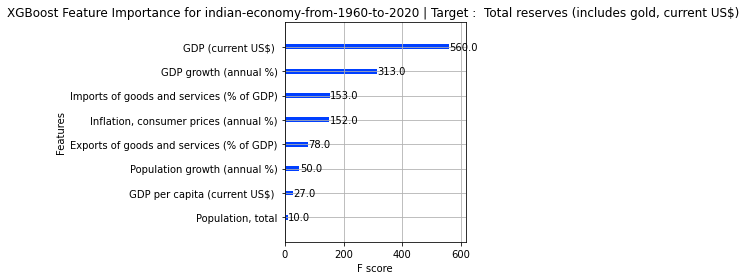

Target Variable: Exports of goods and services (% of GDP)
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:00, 35.62it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9929700032302159, 'Adjusted R-Squared': 0.9613350177661875, 'RMSE': 0.5985454571108733, 'Time taken': 0.07793760299682617}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9927405345349413, 'Adjusted R-Squared': 0.960072939942177, 'RMSE': 0.6082356870585245, 'Time taken': 0.027860403060913086}
{'Model': 'BayesianRidge', 'R-Squared': 0.9917840756149319, 'Adjusted R-Squared': 0.9548124158821253, 'RMSE': 0.6470648266833215, 'Time taken': 0.012309551239013672}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9753727225427526, 'Adjusted R-Squared': 0.8645499739851396, 'RMSE': 1.1202830828038381, 'Time taken': 0.009768486022949219}
{'Model': 'DummyRegressor', 'R-Squared': -0.040375237426134136, 'Adjusted R-Squared': -4.722063805843738, 'RMSE': 7.281395, 'Time taken': 0.009255409240722656}
{'Model': 'ElasticNet', 'R-Squared': 0.904434186695998, 'Adjusted R-Squared': 0.47438802682798875, 'RMSE': 2.20684, 'Time taken': 0.010170221328735352}
{'Model': '

 26%|██▌       | 11/42 [00:00<00:01, 30.83it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9972555786163391, 'Adjusted R-Squared': 0.9849056823898649, 'RMSE': 0.3739770689071639, 'Time taken': 0.11040449142456055}
{'Model': 'GammaRegressor', 'R-Squared': 0.8567076112406558, 'Adjusted R-Squared': 0.21189186182360664, 'RMSE': 2.702284918911904, 'Time taken': 0.013381719589233398}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9884499345908594, 'Adjusted R-Squared': 0.9364746402497266, 'RMSE': 0.7672056597700925, 'Time taken': 0.01223134994506836}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9906795177334806, 'Adjusted R-Squared': 0.9487373475341434, 'RMSE': 0.6891896843875874, 'Time taken': 0.08501768112182617}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9194860864835682, 'Adjusted R-Squared': 0.5571734756596252, 'RMSE': 2.025606325614626, 'Time taken': 0.05544424057006836}
{'Model': 'HuberRegressor', 'R-Squared': 0.9910659401052764, 'Adjusted R-Squared': 0.9508626705790201, 'RMSE': 0.6747517289145121

 48%|████▊     | 20/42 [00:00<00:00, 31.22it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.958739773949414, 'Adjusted R-Squared': 0.7730687567217771, 'RMSE': 1.4500581, 'Time taken': 0.010977745056152344}
{'Model': 'KernelRidge', 'R-Squared': -1.4124254357019725, 'Adjusted R-Squared': -12.26833989636085, 'RMSE': 11.087829, 'Time taken': 0.009621381759643555}
{'Model': 'Lars', 'R-Squared': 0.8769153763404411, 'Adjusted R-Squared': 0.3230345698724263, 'RMSE': 2.5045023, 'Time taken': 0.011338233947753906}
{'Model': 'LarsCV', 'R-Squared': 0.9858483250422461, 'Adjusted R-Squared': 0.9221657877323534, 'RMSE': 0.8492265, 'Time taken': 0.02268362045288086}
{'Model': 'Lasso', 'R-Squared': 0.954207108208686, 'Adjusted R-Squared': 0.7481390951477732, 'RMSE': 1.5276315, 'Time taken': 0.009868860244750977}
{'Model': 'LassoCV', 'R-Squared': 0.9927072475222393, 'Adjusted R-Squared': 0.9598898613723159, 'RMSE': 0.60962856, 'Time taken': 0.060416460037231445}
{'Model': 'LassoLars', 'R-Squared': -0.040375237426134136, 'Adjusted R-Squared': -4.7

 76%|███████▌  | 32/42 [00:01<00:00, 34.36it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6931690885073232, 'Adjusted R-Squared': -0.6875700132097227, 'RMSE': 3.9542954, 'Time taken': 0.12382388114929199}
{'Model': 'NuSVR', 'R-Squared': 0.8870221666729301, 'Adjusted R-Squared': 0.37862191670111556, 'RMSE': 2.3994748209579795, 'Time taken': 0.010993003845214844}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9717749940938801, 'Adjusted R-Squared': 0.8447624675163408, 'RMSE': 1.1993241998206938, 'Time taken': 0.010336637496948242}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9907621215385848, 'Adjusted R-Squared': 0.9491916684622164, 'RMSE': 0.6861288777028322, 'Time taken': 0.015499591827392578}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9799246712812203, 'Adjusted R-Squared': 0.8895856920467116, 'RMSE': 1.0114651151675198, 'Time taken': 0.009708404541015625}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9822926327352488, 'Adjusted R-Squared': 0.9026094800438684, 'RMSE': 0.9499408713677964, 'Time taken': 0

 86%|████████▌ | 36/42 [00:01<00:00, 26.84it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9946282258376442, 'Adjusted R-Squared': 0.9704552421070431, 'RMSE': 0.5232129072620935, 'Time taken': 0.18486499786376953}
{'Model': 'Ridge', 'R-Squared': 0.9931060547894662, 'Adjusted R-Squared': 0.9620833013420642, 'RMSE': 0.59272534, 'Time taken': 0.01109170913696289}
{'Model': 'RidgeCV', 'R-Squared': 0.9920779601550181, 'Adjusted R-Squared': 0.9564287808525997, 'RMSE': 0.6353866524624043, 'Time taken': 0.009818077087402344}
{'Model': 'SGDRegressor', 'R-Squared': 0.9930854677241123, 'Adjusted R-Squared': 0.9619700724826178, 'RMSE': 0.5936096880518931, 'Time taken': 0.011869192123413086}
{'Model': 'SVR', 'R-Squared': 0.923877165140396, 'Adjusted R-Squared': 0.5813244082721778, 'RMSE': 1.9695955430092025, 'Time taken': 0.009945392608642578}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9901040024862622, 'Adjusted R-Squared': 0.945572013674442, 'RMSE': 0.7101488, 'Time taken': 0.010219335556030273}
{'Model': 'TweedieRegressor',

100%|██████████| 42/42 [00:01<00:00, 24.90it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9826115738496233, 'Adjusted R-Squared': 0.904363656172928, 'RMSE': 0.94134694, 'Time taken': 0.3661174774169922}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9089900174583185, 'Adjusted R-Squared': 0.49944509602075193, 'RMSE': 2.1535952849314115, 'Time taken': 0.029310226440429688}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: Exports of goods and services (% of GDP)
Exports of goods and services (% of GDP)
Target Standard Deviation: 6.939441204071045
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.98       1.00  0.37        0.11
RandomForestRegressor                        0.97       0.99  0.52        0.18
ExtraTreeRegressor                           0.97       0.99  0.53        0.01
LinearSVR                                    0.96       0.99  0.57        

Better model found at epoch 0 with _rmse value: 38.785011291503906.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    4.14       4.62
1   10.84       9.90
2   24.53      24.54
3    5.60       6.21
4    5.94       6.04
XGBoost RMSE:  0.94134694


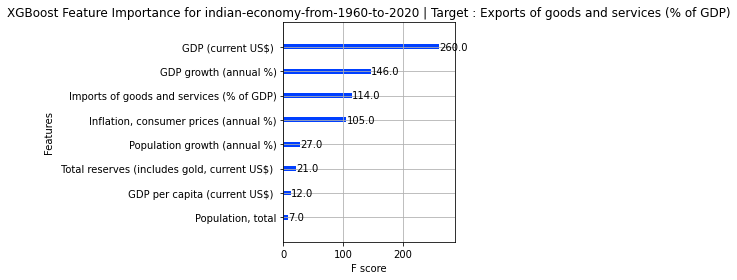

Target Variable: Imports of goods and services (% of GDP)
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'GDP growth (annual %)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:00, 35.84it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9640356582301852, 'Adjusted R-Squared': 0.8021961202660187, 'RMSE': 1.8056261880690878, 'Time taken': 0.07968735694885254}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9836671393527856, 'Adjusted R-Squared': 0.9101692664403208, 'RMSE': 1.2168104063527057, 'Time taken': 0.027559518814086914}
{'Model': 'BayesianRidge', 'R-Squared': 0.9825827762966215, 'Adjusted R-Squared': 0.9042052696314182, 'RMSE': 1.256554274361322, 'Time taken': 0.01208186149597168}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8416488842455854, 'Adjusted R-Squared': 0.12906886335071954, 'RMSE': 3.7888058457579423, 'Time taken': 0.009463310241699219}
{'Model': 'DummyRegressor', 'R-Squared': -0.09706203813542613, 'Adjusted R-Squared': -5.0338412097448435, 'RMSE': 9.972577, 'Time taken': 0.00871896743774414}
{'Model': 'ElasticNet', 'R-Squared': 0.8024272282526184, 'Adjusted R-Squared': -0.086650244610599, 'RMSE': 4.2320943, 'Time taken': 0.00951695442199707}
{'Model': '

 26%|██▌       | 11/42 [00:00<00:01, 30.47it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9843348173031436, 'Adjusted R-Squared': 0.9138414951672901, 'RMSE': 1.191679638849298, 'Time taken': 0.11391901969909668}
{'Model': 'GammaRegressor', 'R-Squared': 0.7664268892331283, 'Adjusted R-Squared': -0.28465210921779427, 'RMSE': 4.60154008147308, 'Time taken': 0.013740777969360352}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.38317012348170787, 'Adjusted R-Squared': -2.3925643208506067, 'RMSE': 7.477811052603123, 'Time taken': 0.012877225875854492}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9598201753675004, 'Adjusted R-Squared': 0.7790109645212523, 'RMSE': 1.9085160006239392, 'Time taken': 0.09058070182800293}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6576606462902452, 'Adjusted R-Squared': -0.8828664454036512, 'RMSE': 5.5708337766026474, 'Time taken': 0.061428070068359375}


 48%|████▊     | 20/42 [00:00<00:00, 29.52it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9923468660295994, 'Adjusted R-Squared': 0.9579077631627968, 'RMSE': 0.8329356391442719, 'Time taken': 0.04020547866821289}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9362476801153337, 'Adjusted R-Squared': 0.6493622406343351, 'RMSE': 2.4040294, 'Time taken': 0.012180805206298828}
{'Model': 'KernelRidge', 'R-Squared': -0.5667537075482836, 'Adjusted R-Squared': -7.61714539151556, 'RMSE': 11.917691, 'Time taken': 0.011812448501586914}
{'Model': 'Lars', 'R-Squared': 0.9921355143250994, 'Adjusted R-Squared': 0.9567453287880466, 'RMSE': 0.8443586, 'Time taken': 0.011857986450195312}
{'Model': 'LarsCV', 'R-Squared': 0.9924445259832135, 'Adjusted R-Squared': 0.9584448929076744, 'RMSE': 0.8276041, 'Time taken': 0.02479267120361328}
{'Model': 'Lasso', 'R-Squared': 0.9501968145776902, 'Adjusted R-Squared': 0.7260824801772963, 'RMSE': 2.1248112, 'Time taken': 0.010523557662963867}
{'Model': 'LassoCV', 'R-Squared': 0.9811567322013247, 'Adjusted R-Squa

 62%|██████▏   | 26/42 [00:00<00:00, 29.16it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9371046195057666, 'Adjusted R-Squared': 0.6540754072817164, 'RMSE': 2.387817667806175, 'Time taken': 0.011287450790405273}
{'Model': 'MLPRegressor', 'R-Squared': 0.5668621051312204, 'Adjusted R-Squared': -1.382258421778288, 'RMSE': 6.2662096, 'Time taken': 0.12961626052856445}
{'Model': 'NuSVR', 'R-Squared': 0.6966660884417997, 'Adjusted R-Squared': -0.6683365135701018, 'RMSE': 5.243874262260156, 'Time taken': 0.01142740249633789}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9745627204905936, 'Adjusted R-Squared': 0.8600949626982646, 'RMSE': 1.5185430830962725, 'Time taken': 0.010805130004882812}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9835016711683352, 'Adjusted R-Squared': 0.9092591914258437, 'RMSE': 1.2229586258099088, 'Time taken': 0.01684737205505371}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9595059526282823, 'Adjusted R-Squared': 0.7772827394555527, 'RMSE': 1.915964156756527, 'Time taken': 0.009833097457

 76%|███████▌  | 32/42 [00:01<00:00, 31.62it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.4921086707759941, 'Adjusted R-Squared': -7.2065976892679675, 'RMSE': 11.630329365944784, 'Time taken': 0.09786224365234375}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9909604413445485, 'Adjusted R-Squared': 0.9502824273950169, 'RMSE': 0.90524346, 'Time taken': 0.03687763214111328}


 86%|████████▌ | 36/42 [00:01<00:00, 25.64it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.976882028852792, 'Adjusted R-Squared': 0.8728511586903558, 'RMSE': 1.4476602363557243, 'Time taken': 0.17976713180541992}
{'Model': 'Ridge', 'R-Squared': 0.96264684450401, 'Adjusted R-Squared': 0.7945576447720547, 'RMSE': 1.8401593, 'Time taken': 0.009980916976928711}
{'Model': 'RidgeCV', 'R-Squared': 0.9804559480569417, 'Adjusted R-Squared': 0.8925077143131793, 'RMSE': 1.3310644699636949, 'Time taken': 0.009815692901611328}
{'Model': 'SGDRegressor', 'R-Squared': 0.9552262765623147, 'Adjusted R-Squared': 0.753744521092731, 'RMSE': 2.0146675578600366, 'Time taken': 0.011747598648071289}
{'Model': 'SVR', 'R-Squared': 0.715907285250415, 'Adjusted R-Squared': -0.5625099311227173, 'RMSE': 5.074833935189616, 'Time taken': 0.009526491165161133}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9921361746426414, 'Adjusted R-Squared': 0.9567489605345275, 'RMSE': 0.84432316, 'Time taken': 0.009740591049194336}
{'Model': 'TweedieRegressor', '

100%|██████████| 42/42 [00:01<00:00, 23.92it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9736684479778783, 'Adjusted R-Squared': 0.8551764638783308, 'RMSE': 1.5450054, 'Time taken': 0.37429141998291016}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6804430209303982, 'Adjusted R-Squared': -0.7575633848828098, 'RMSE': 5.382275702185803, 'Time taken': 0.028052091598510742}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: Imports of goods and services (% of GDP)
Imports of goods and services (% of GDP)
Target Standard Deviation: 7.58313512802124
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                  0.96       0.99  0.81        0.01
LarsCV                                       0.96       0.99  0.83        0.02
HuberRegressor                               0.96       0.99  0.83        0.04
LassoLarsCV                                  0.96       0.99  0.84        0

Better model found at epoch 0 with _rmse value: 31.274829864501953.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   11.93      12.75
1    9.82      10.30
2   29.27      30.51
3   28.41      31.26
4    8.49       9.41
XGBoost RMSE:  1.5450054


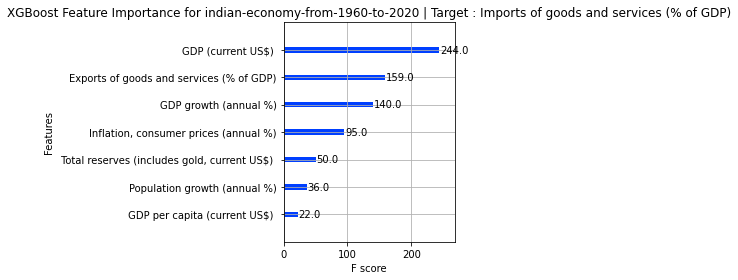

Target Variable: GDP growth (annual %)
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', ' GDP per capita (current US$) ', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', ' GDP per capita (current US$) ', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


  5%|▍         | 2/42 [00:00<00:02, 18.23it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.5897288181416143, 'Adjusted R-Squared': -7.743508499778878, 'RMSE': 3.155226047104894, 'Time taken': 0.07925772666931152}
{'Model': 'BaggingRegressor', 'R-Squared': -0.622815970903658, 'Adjusted R-Squared': -7.925487839970119, 'RMSE': 3.1878919387263607, 'Time taken': 0.03028249740600586}
{'Model': 'BayesianRidge', 'R-Squared': -0.06391754090243595, 'Adjusted R-Squared': -4.851546474963397, 'RMSE': 2.581207626063647, 'Time taken': 0.015270471572875977}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -2.934217908513047, 'Adjusted R-Squared': -20.638198496821758, 'RMSE': 4.963615823962575, 'Time taken': 0.010511636734008789}
{'Model': 'DummyRegressor', 'R-Squared': -0.02976430424793386, 'Adjusted R-Squared': -4.663703673363636, 'RMSE': 2.5394397, 'Time taken': 0.009638547897338867}
{'Model': 'ElasticNet', 'R-Squared': 0.03661924570517672, 'Adjusted R-Squared': -4.298594148621528, 'RMSE': 2.4562237, 'Time taken': 0.01047968864440918}


 17%|█▋        | 7/42 [00:00<00:01, 27.18it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.023003679730022042, 'Adjusted R-Squared': -4.373479761484878, 'RMSE': 2.47352, 'Time taken': 0.11129951477050781}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.7497892991658848, 'Adjusted R-Squared': -8.623841145412367, 'RMSE': 3.3102579182093805, 'Time taken': 0.011391162872314453}


 24%|██▍       | 10/42 [00:00<00:01, 25.07it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.2186714203430007, 'Adjusted R-Squared': -5.702692811886504, 'RMSE': 2.762563491629579, 'Time taken': 0.11363816261291504}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.376303135051569, 'Adjusted R-Squared': -39.56966724278363, 'RMSE': 6.796547132612042, 'Time taken': 0.019116640090942383}


 31%|███       | 13/42 [00:00<00:01, 21.50it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.44134064744308166, 'Adjusted R-Squared': -6.92737356093695, 'RMSE': 3.0043620821509993, 'Time taken': 0.09641528129577637}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.0677274156757679, 'Adjusted R-Squared': -4.127499213783277, 'RMSE': 2.4162419015006926, 'Time taken': 0.0567476749420166}


 45%|████▌     | 19/42 [00:00<00:00, 31.21it/s]

{'Model': 'HuberRegressor', 'R-Squared': -0.2955448142387789, 'Adjusted R-Squared': -6.125496478313284, 'RMSE': 2.848361946653708, 'Time taken': 0.038423776626586914}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.26502004265073764, 'Adjusted R-Squared': -5.957610234579057, 'RMSE': 2.8146064, 'Time taken': 0.011069536209106445}
{'Model': 'KernelRidge', 'R-Squared': -4.814571225398215, 'Adjusted R-Squared': -30.980141739690183, 'RMSE': 6.0343127, 'Time taken': 0.010133028030395508}
{'Model': 'Lars', 'R-Squared': -2.828278286053293, 'Adjusted R-Squared': -20.05553057329311, 'RMSE': 4.89633, 'Time taken': 0.011448860168457031}
{'Model': 'LarsCV', 'R-Squared': 0.011327874760415635, 'Adjusted R-Squared': -4.437696688817714, 'RMSE': 2.4882565, 'Time taken': 0.023650407791137695}
{'Model': 'Lasso', 'R-Squared': -0.02976430424793386, 'Adjusted R-Squared': -4.663703673363636, 'RMSE': 2.5394397, 'Time taken': 0.010144472122192383}


 62%|██████▏   | 26/42 [00:01<00:00, 24.04it/s]

{'Model': 'LassoCV', 'R-Squared': -0.24289225263723568, 'Adjusted R-Squared': -5.835907389504796, 'RMSE': 2.789881, 'Time taken': 0.1533045768737793}
{'Model': 'LassoLars', 'R-Squared': -0.02976430424793386, 'Adjusted R-Squared': -4.663703673363636, 'RMSE': 2.5394397, 'Time taken': 0.010780096054077148}
{'Model': 'LassoLarsCV', 'R-Squared': -0.33675198690492714, 'Adjusted R-Squared': -6.352135927977099, 'RMSE': 2.8933063, 'Time taken': 0.03330111503601074}
{'Model': 'LassoLarsIC', 'R-Squared': -0.28164520191642617, 'Adjusted R-Squared': -6.049048610540344, 'RMSE': 2.833041, 'Time taken': 0.015398740768432617}
{'Model': 'LinearRegression', 'R-Squared': -0.33661189985635764, 'Adjusted R-Squared': -6.351365449209967, 'RMSE': 2.8931546, 'Time taken': 0.010463953018188477}
{'Model': 'LinearSVR', 'R-Squared': -0.41919453431278764, 'Adjusted R-Squared': -6.805569938720332, 'RMSE': 2.981191813016879, 'Time taken': 0.011366605758666992}
{'Model': 'MLPRegressor', 'R-Squared': -0.9341155707590452

 76%|███████▌  | 32/42 [00:01<00:00, 30.22it/s]

{'Model': 'NuSVR', 'R-Squared': 0.11687632351051447, 'Adjusted R-Squared': -3.857180220692171, 'RMSE': 2.3516880867199577, 'Time taken': 0.011661767959594727}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.10649792941443648, 'Adjusted R-Squared': -3.9142613882205994, 'RMSE': 2.3654661441876037, 'Time taken': 0.010255098342895508}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.00011770701003399608, 'Adjusted R-Squared': -4.500647388555187, 'RMSE': 2.5026177078350402, 'Time taken': 0.015755414962768555}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.6614249231508624, 'Adjusted R-Squared': -8.137837077329744, 'RMSE': 3.2255911247900824, 'Time taken': 0.009667396545410156}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution
{'Model': 'QuantileRegressor', 'R-Squared': -0.009585039769663739, 'Adjusted R-Squared': -4.552717718733151, 'RMSE': 2.514434970555741, 'Time taken': 0.07485795021057129}


 86%|████████▌ | 36/42 [00:01<00:00, 22.45it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.7296240352617225, 'Adjusted R-Squared': -8.512932193939474, 'RMSE': 3.2911282, 'Time taken': 0.12327241897583008}
{'Model': 'RandomForestRegressor', 'R-Squared': -0.2863490266745641, 'Adjusted R-Squared': -6.074919646710103, 'RMSE': 2.8382350964746434, 'Time taken': 0.14484882354736328}
{'Model': 'Ridge', 'R-Squared': -0.1268463836977749, 'Adjusted R-Squared': -5.197655110337762, 'RMSE': 2.656448, 'Time taken': 0.010199308395385742}
{'Model': 'RidgeCV', 'R-Squared': -0.07241151242496535, 'Adjusted R-Squared': -4.898263318337309, 'RMSE': 2.5914909032528484, 'Time taken': 0.010159015655517578}
{'Model': 'SGDRegressor', 'R-Squared': -0.07672781314508259, 'Adjusted R-Squared': -4.922002972297954, 'RMSE': 2.5967008536110785, 'Time taken': 0.011772871017456055}
{'Model': 'SVR', 'R-Squared': 0.12136084259525581, 'Adjusted R-Squared': -3.832515365726093, 'RMSE': 2.3457095284906404, 'Time taken': 0.009591102600097656}
{'Model': 'TransformedTargetRegr

100%|██████████| 42/42 [00:01<00:00, 21.84it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.6016891683880254, 'Adjusted R-Squared': -7.80929042613414, 'RMSE': 3.1670732, 'Time taken': 0.37694478034973145}
{'Model': 'LGBMRegressor', 'R-Squared': 0.09070482164056748, 'Adjusted R-Squared': -4.0011234809768785, 'RMSE': 2.3862799874164984, 'Time taken': 0.030744314193725586}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target: GDP growth (annual %)
GDP growth (annual %)
Target Standard Deviation: 3.482764482498169
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
SVR                                         -3.83       0.12  2.35        0.01
NuSVR                                       -3.86       0.12  2.35        0.01
OrthogonalMatchingPursuit                   -3.91       0.11  2.37        0.01
LGBMRegressor                               -4.00       0.09  2.39        0.03
HistGradientBoostingRegressor  

Better model found at epoch 0 with _rmse value: 7.4152936935424805.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    9.15       2.02
1    1.64       4.25
2    3.82       5.42
3    7.55       7.87
4    4.05       7.83
XGBoost RMSE:  3.1670732


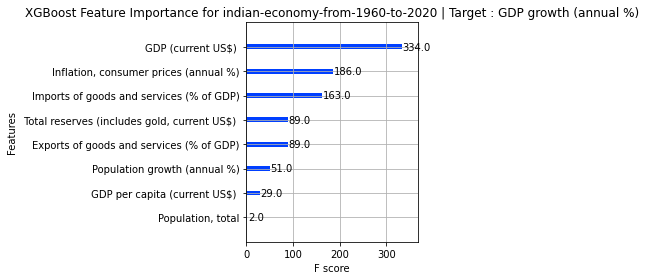

Target Variable:  GDP per capita (current US$) 
CATS=====================
[]
CONTS=====================
['GDP (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['GDP (current US$) ', 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)', 'Exports of goods and services (% of GDP)', ' Total reserves (includes gold, current US$) ', 'Inflation, consumer prices (annual %)', 'Population, total', 'Population growth (annual %)', 'Life expectancy at birth, total (years)']
Categorical variables that made the cut : []
Tabular Object size: 61
problem with getting one batch of indian-economy-from-1960-to-2020


 17%|█▋        | 7/42 [00:00<00:00, 35.63it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9692460416328266, 'Adjusted R-Squared': 0.8308532289805461, 'RMSE': 41.93469775733455, 'Time taken': 0.0769813060760498}
{'Model': 'BaggingRegressor', 'R-Squared': 0.950470773072707, 'Adjusted R-Squared': 0.7275892518998885, 'RMSE': 53.21741569574132, 'Time taken': 0.027173519134521484}
{'Model': 'BayesianRidge', 'R-Squared': 0.9979564903095223, 'Adjusted R-Squared': 0.9887606967023725, 'RMSE': 10.809643143227937, 'Time taken': 0.012189388275146484}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9682874158473503, 'Adjusted R-Squared': 0.8255807871604268, 'RMSE': 42.58325179379016, 'Time taken': 0.010410308837890625}
{'Model': 'DummyRegressor', 'R-Squared': -0.7799768266531317, 'Adjusted R-Squared': -8.789872546592225, 'RMSE': 319.02902, 'Time taken': 0.009250879287719727}
{'Model': 'ElasticNet', 'R-Squared': 0.7109837964019355, 'Adjusted R-Squared': -0.5895891197893546, 'RMSE': 128.55356, 'Time taken': 0.010410547256469727}
{'Model': 'El

 26%|██▌       | 11/42 [00:00<00:01, 30.46it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9855058772343928, 'Adjusted R-Squared': 0.9202823247891602, 'RMSE': 28.788495821537232, 'Time taken': 0.11443710327148438}
{'Model': 'GammaRegressor', 'R-Squared': 0.9506524007667032, 'Adjusted R-Squared': 0.7285882042168677, 'RMSE': 53.119749785564224, 'Time taken': 0.012600183486938477}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9183786945459609, 'Adjusted R-Squared': 0.5510828200027849, 'RMSE': 68.31636881433602, 'Time taken': 0.012936592102050781}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9768217066948832, 'Adjusted R-Squared': 0.8725193868218577, 'RMSE': 36.4052261531002, 'Time taken': 0.08705520629882812}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -2.866864919821231, 'Adjusted R-Squared': -20.26775705901677, 'RMSE': 470.22152622904, 'Time taken': 0.056543827056884766}


 48%|████▊     | 20/42 [00:00<00:00, 30.66it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9979296612129192, 'Adjusted R-Squared': 0.9886131366710553, 'RMSE': 10.880371280541828, 'Time taken': 0.03783464431762695}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8403220509401663, 'Adjusted R-Squared': 0.12177128017091476, 'RMSE': 95.55325, 'Time taken': 0.011077642440795898}
{'Model': 'KernelRidge', 'R-Squared': -5.542735764469906, 'Adjusted R-Squared': -34.985046704584484, 'RMSE': 611.64966, 'Time taken': 0.011092185974121094}
{'Model': 'Lars', 'R-Squared': -0.20557907905910278, 'Adjusted R-Squared': -5.630684934825065, 'RMSE': 262.55533, 'Time taken': 0.01237630844116211}
{'Model': 'LarsCV', 'R-Squared': 0.9912244806480789, 'Adjusted R-Squared': 0.9517346435644338, 'RMSE': 22.400589, 'Time taken': 0.022932767868041992}
{'Model': 'Lasso', 'R-Squared': 0.9936353941872371, 'Adjusted R-Squared': 0.9649946680298042, 'RMSE': 19.076942, 'Time taken': 0.01029205322265625}
{'Model': 'LassoCV', 'R-Squared': 0.9953967881357207, 'Adjusted R-Sq

 76%|███████▌  | 32/42 [00:01<00:00, 31.94it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.629045738304234, 'Adjusted R-Squared': -18.959751560673286, 'RMSE': 455.53235, 'Time taken': 0.12616443634033203}
{'Model': 'NuSVR', 'R-Squared': -0.5538745911796759, 'Adjusted R-Squared': -7.546310251488217, 'RMSE': 298.0787310696789, 'Time taken': 0.010269880294799805}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9840461518638834, 'Adjusted R-Squared': 0.912253835251359, 'RMSE': 30.20339295629949, 'Time taken': 0.009469985961914062}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9928849041426637, 'Adjusted R-Squared': 0.9608669727846505, 'RMSE': 20.170347660554754, 'Time taken': 0.015018463134765625}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9897438835283248, 'Adjusted R-Squared': 0.9435913594057862, 'RMSE': 24.216673041810616, 'Time taken': 0.00973057746887207}
{'Model': 'PoissonRegressor', 'R-Squared': 0.98722040116195, 'Adjusted R-Squared': 0.9297122063907248, 'RMSE': 27.032213992342047, 'Time taken': 0.02424

 86%|████████▌ | 36/42 [00:01<00:00, 25.82it/s]

{'Model': 'RidgeCV', 'R-Squared': 0.9969898926212521, 'Adjusted R-Squared': 0.9834444094168868, 'RMSE': 13.119400808482775, 'Time taken': 0.012155294418334961}
{'Model': 'SGDRegressor', 'R-Squared': 0.9916246138278844, 'Adjusted R-Squared': 0.953935376053364, 'RMSE': 21.883935518855615, 'Time taken': 0.017812490463256836}
{'Model': 'SVR', 'R-Squared': -0.11992470510019149, 'Adjusted R-Squared': -5.159585878051053, 'RMSE': 253.05645434633806, 'Time taken': 0.010015010833740234}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.997971228861934, 'Adjusted R-Squared': 0.9888417587406371, 'RMSE': 10.770591, 'Time taken': 0.010114669799804688}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6531286894498911, 'Adjusted R-Squared': -0.9077922080255989, 'RMSE': 140.8338969904872, 'Time taken': 0.011783599853515625}


100%|██████████| 42/42 [00:01<00:00, 23.89it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9778493450435581, 'Adjusted R-Squared': 0.8781713977395698, 'RMSE': 35.589043, 'Time taken': 0.388751745223999}
{'Model': 'LGBMRegressor', 'R-Squared': -2.7106983688537865, 'Adjusted R-Squared': -19.408841028695825, 'RMSE': 460.6285293755474, 'Time taken': 0.030368328094482422}
Project: indian-economy-from-1960-to-2020
indian-economy-from-1960-to-2020
Target:  GDP per capita (current US$) 
 GDP per capita (current US$) 
Target Standard Deviation: 628.4550170898438
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
RANSACRegressor                              0.99       1.00  10.77   
TransformedTargetRegressor                   0.99       1.00  10.77   
LinearRegression                             0.99       1.00  10.77   
BayesianRidge                                0.99       1.00  10.81   
LassoLarsIC                                  0.99       1.00  10

Better model found at epoch 0 with _rmse value: 462.6142578125.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  340.00     310.00
1   82.00      90.52
2  368.00     342.12
3  301.00     309.89
4  715.00     626.46
XGBoost RMSE:  35.589043


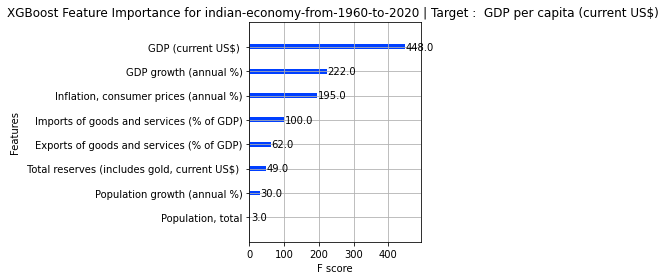

<Figure size 432x288 with 0 Axes>

In [20]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                                    feature  importance
0                        GDP (current US$)       543.00
1             GDP per capita (current US$)        31.00
2                     GDP growth (annual %)      295.00
3  Imports of goods and services (% of GDP)      150.00
4  Exports of goods and services (% of GDP)      102.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

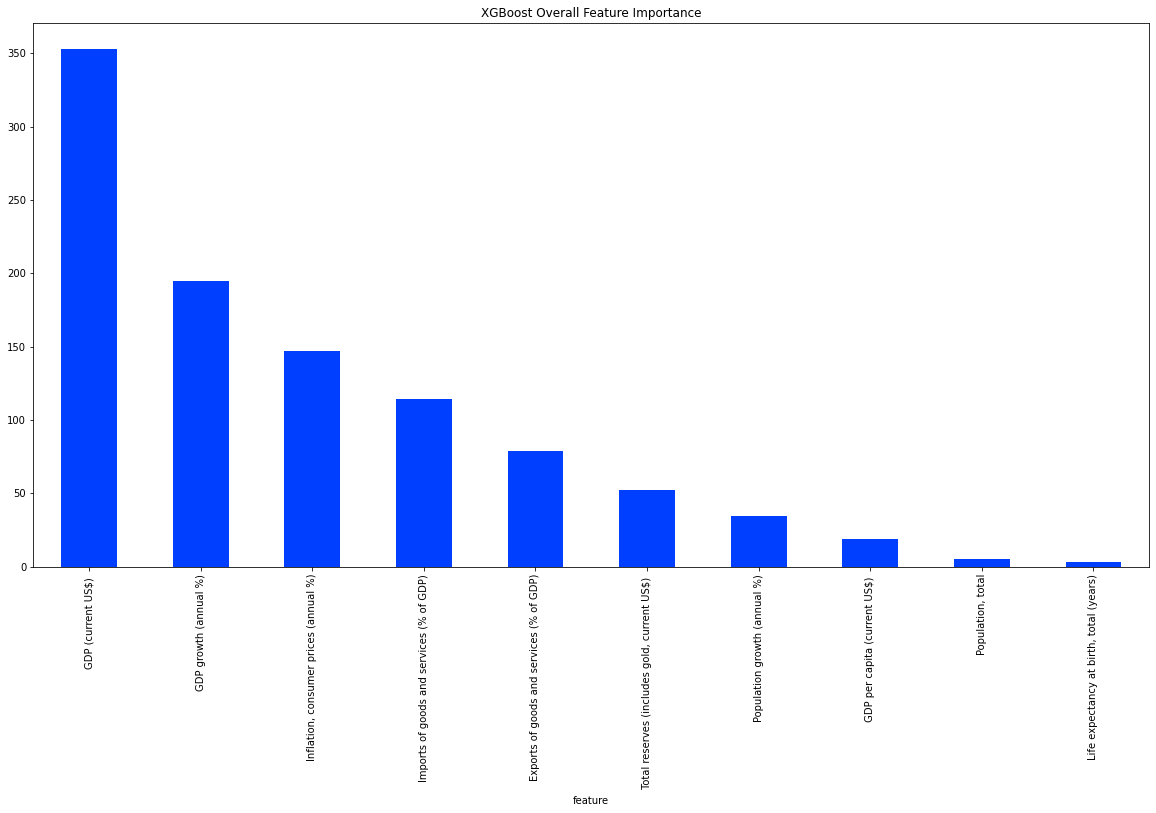

In [21]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [22]:
df.isna().sum()

GDP (current US$)                                0
 GDP per capita (current US$)                    0
GDP growth (annual %)                            0
Imports of goods and services (% of GDP)         0
Exports of goods and services (% of GDP)         0
 Total reserves (includes gold, current US$)     0
Inflation, consumer prices (annual %)            0
Population, total                                0
Population growth (annual %)                     0
Life expectancy at birth, total (years)          0
dtype: int64

# **To Be Continued...**